In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Science/Jax_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

#Optimizer
from jax.scipy.optimize import minimize as jax_minimize
from scipy.optimize import minimize as scipy_minimize

#Jaxtronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters



#Jaxified GRF generator
from jaxtronomy.GaussianRandomField.PowerBox_jaxified import get_jaxified_GRF
import jaxtronomy.GaussianRandomField.PowerBox_jaxified as PowerBox_jax

#Utils for GRF fitting
from jaxtronomy.GaussianRandomField.GRF_fitting import get_parameters,get_lens_models,simulate_perturbed_image,simulate_smooth_image,model_loss_function
#Utils for computing axially averaged spectrum
from jaxtronomy.GaussianRandomField.GRF_fitting import Radial_profile,compute_radial_spectrum
#Utils for fitting the GRF
from jaxtronomy.GaussianRandomField.GRF_fitting import GRF_Loss_perfect_case,GRF_Loss_phase_averaging,GRF_Loss_image_fitting,Spectra_Loss_MSE,Spectra_Loss_MAE
from jaxtronomy.GaussianRandomField.GRF_fitting import fit_image_function,GRF_Loss_complete

#Utils for handling jax
from jaxtronomy.GaussianRandomField.Jax_Utils import purify_function,jax_map,gradient_descent



# Universal font size
FS = 18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Lensing setup (unknown to us)

In [2]:
#GRF true parameters
GRF_LogAmp=-7.
GRF_beta=2.
GRF_seed=1

GRF_params=[GRF_LogAmp,GRF_beta]

## Data grids

In [3]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
x_coords = xgrid[0, :]
y_coords = ygrid[:, 0]

## Models

In [4]:
#Source light
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]

#Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)
GRF_realisation=get_jaxified_GRF([GRF_LogAmp,GRF_beta],GRF_seed,npix,pix_scl)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

#Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

## Source light model

In [5]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]

## Lens model (SIE + external shear)

In [6]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)

GRF_realisation=get_jaxified_GRF([GRF_LogAmp,GRF_beta],GRF_seed,npix,pix_scl)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

#Combined kwargs smooth
kwargs_data = {'kwargs_lens': kwargs_lens_mass[:-1], 'kwargs_source': kwargs_source_light,'kwargs_lens_light':kwargs_lens_light}

#Observation conditions and noise
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1}

SNR=1000
kwargs_noise={'background_rms': 0.5/SNR, 'exposure_time': np.inf}
noise=Noise(npix, npix, **kwargs_noise)

parameters=get_parameters(kwargs_data,lens_mass_model_list,source_light_model_list)

#Noiseless models
perturbed_lens_image,smooth_lens_image=get_lens_models(pixel_grid,psf,noise,\
                                                       lens_mass_model_list,source_light_model,lens_light_model,kwargs_numerics)

## Perturbed and unperturbed images

In [7]:
smooth_lens_image.simulation(compute_true_noise_map=True,**kwargs_data)
data_image=simulate_perturbed_image(GRF_realisation,kwargs_data,perturbed_lens_image,x_coords,y_coords)
unperturbed_data_image=simulate_smooth_image(kwargs_data,smooth_lens_image)

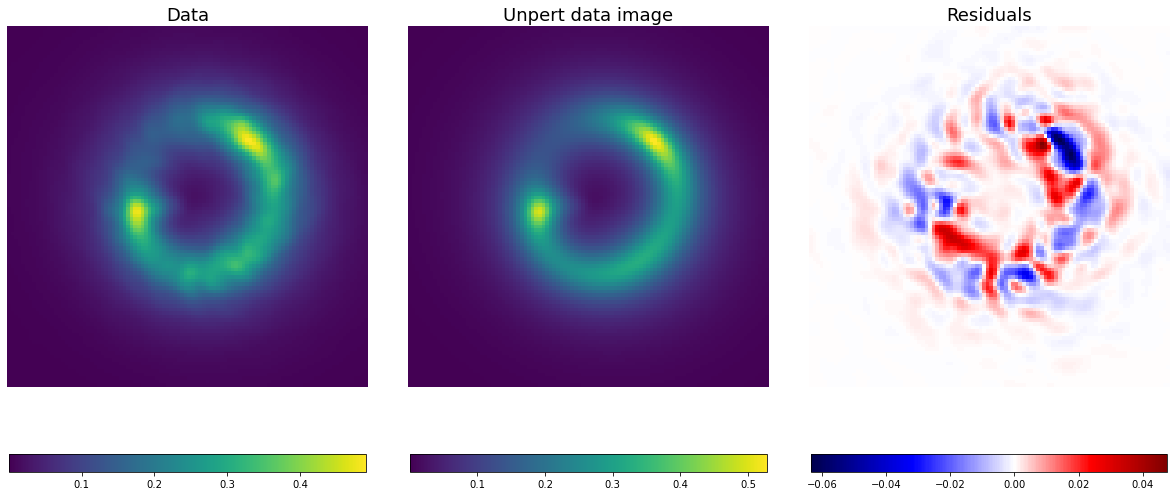

In [8]:
parameter_names=deepcopy(parameters.symbols)

parameter_names[1:5]=['$e_1^{lens}$','$e_2^{lens}$','$x_{0}^{lens}$', '$y_{0}^{lens}$']
parameter_names[-4:]=['$e_1^{source}$','$e_2^{source}$','$x_{0}^{source}$', '$y_{0}^{source}$']

fig,ax=plt.subplots(1,3,figsize=(20,7))

im_arr=[]

im=ax[0].imshow(data_image,origin='lower')
im_arr+=[im]
ax[0].set_title('Data',fontsize=FS)


im=ax[1].imshow(unperturbed_data_image,origin='lower')
im_arr+=[im]
ax[1].set_title('Unpert data image',fontsize=FS)

im=ax[2].imshow(data_image-unperturbed_data_image,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
im_arr+=[im]
ax[2].set_title('Residuals',fontsize=FS)

for i in range(3):
    ax[i].axis('off')
    fig.colorbar(im_arr[i],ax=ax[i],orientation='horizontal',fraction=0.04)
    
fig.tight_layout(w_pad=-20)
plt.show()

In [9]:
(data_image-unperturbed_data_image).max()

DeviceArray(0.04768926, dtype=float64)

In [10]:

# True lens mass model
true_lens_mass_model_list = ['PIXELATED']
true_lens_mass_model = LensModel(true_lens_mass_model_list)
kwargs_true_lens_mass = [{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

In [11]:
GRF_lens_model=LensModel(['PIXELATED'])

def get_residuals(GRF_realisation):
    perturbed_images=simulate_perturbed_image(GRF_realisation,kwargs_data,perturbed_lens_image,x_coords,y_coords)
    return perturbed_images-unperturbed_data_image

def get_GRF_characteristics(logA,Beta):
    
    GRF_realisation=get_jaxified_GRF([logA,Beta],GRF_seed,npix,pix_scl)

    kwargs=[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]
    
    potential=GRF_lens_model.potential(xgrid, ygrid, kwargs)
    deflection=GRF_lens_model.alpha(xgrid, ygrid, kwargs)
    convergence=GRF_lens_model.kappa(xgrid, ygrid, kwargs)
    magnification=GRF_lens_model.magnification(xgrid, ygrid, kwargs)
    
    residuals=get_residuals(GRF_realisation)
    
    return potential,deflection,convergence,magnification,residuals

In [12]:
_,_,_,_,residuals=get_GRF_characteristics(-7.,2.)
residuals.max()/unperturbed_data_image.max()

DeviceArray(0.09042408, dtype=float64)

In [13]:
_,_,_,_,residuals=get_GRF_characteristics(-7.32,3.)
residuals.max()/unperturbed_data_image.max()

DeviceArray(0.09026309, dtype=float64)

In [14]:
_,_,_,_,residuals=get_GRF_characteristics(-7.8,4.)
residuals.max()/unperturbed_data_image.max()

DeviceArray(0.09005974, dtype=float64)

In [15]:
_,_,_,_,residuals=get_GRF_characteristics(-8.45,5.)
residuals.max()/unperturbed_data_image.max()

DeviceArray(0.09003387, dtype=float64)

In [16]:
_,_,_,_,residuals=get_GRF_characteristics(-9.27,6.)
residuals.max()/unperturbed_data_image.max()

DeviceArray(0.09066521, dtype=float64)

In [17]:
_,_,_,_,residuals=get_GRF_characteristics(-10.1,7.)
residuals.max()/unperturbed_data_image.max()

DeviceArray(0.09092003, dtype=float64)

In [18]:
_,_,_,_,residuals=get_GRF_characteristics(-10.95,8.)
residuals.max()/unperturbed_data_image.max()

DeviceArray(0.09043162, dtype=float64)

In [19]:
logA_array=np.array([-7,-7.32,-7.8,-8.45,-9.27,-10.1])
Beta_array=np.array([2,3,4,5,6,7])

In [20]:
potentials=np.zeros((len(logA_array),npix,npix))
deflections_x=np.zeros_like(potentials)
deflections_y=np.zeros_like(potentials)
convergences=np.zeros_like(potentials)
magnifications=np.zeros_like(potentials)
residuals=np.zeros_like(potentials)

for i in tqdm(range(len(logA_array))):
    potential,deflection,convergence,magnification,residual=get_GRF_characteristics(logA_array[i],Beta_array[i])
    
    potentials[i]=potential
    deflections_x[i]=deflection[0]
    deflections_y[i]=deflection[1]
    convergences[i]=convergence
    magnifications[i]=magnification
    residuals[i]=residual

100%|██████████████████████████████████████████| 6/6 [00:01<00:00,  5.67it/s]


# Relation between strength of perturbation residuals and GRF characteristics 

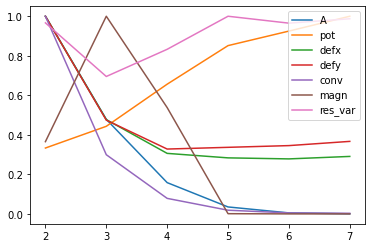

In [21]:
def get_data(func):
    
    temp=np.array([logA_array,Beta_array,func(potentials),func(deflections_x),func(deflections_y),\
               func(convergences),func(magnifications),residuals.max(axis=(1,2)),residuals.std(axis=(1,2))**2])
    
    return temp
    
    
#temp=np.array([logA_array,Beta_array,potentials.std(axis=(1,2)),deflections_x.std(axis=(1,2)),deflections_y.std(axis=(1,2)),\
               #convergences.std(axis=(1,2)),residuals.max(axis=(1,2)),residuals.std(axis=(1,2))**2])

temp=get_data(lambda x: x.std(axis=(1,2)))

df=pd.DataFrame(data=temp.T,columns=['logA','Beta','pot','defx','defy','conv','magn','res_max','res_var'])
df['A']=np.power(10,df['logA'])

q='A'

for name in ['A','pot','defx','defy','conv','magn','res_var']:
    plt.plot(df['Beta'],df[name]/df[name].max(),label=name)
    #plt.yscale('log')
plt.legend()

In [185]:
GRF_realisation.std()

DeviceArray(0.01501326, dtype=float64)

In [203]:
def get_residuals_from_pot_std(potential_std,Beta):
    GRF_sample=get_jaxified_GRF([-10,Beta],GRF_seed,npix,pix_scl)
    
    GRF_realisation=potential_std*GRF_sample/GRF_sample.std()
    
    perturbed_images=simulate_perturbed_image(GRF_realisation,kwargs_data,perturbed_lens_image,x_coords,y_coords)
    return perturbed_images-unperturbed_data_image

In [195]:
residuals=np.array([get_residuals_from_var(0.001,Beta) for Beta in Beta_array])

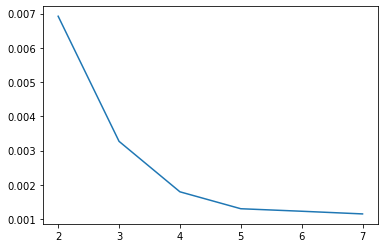

In [196]:
plt.plot(Beta_array,residuals.max(axis=(1,2)))

In [197]:
residuals.max(axis=(1,2))

array([0.00692174, 0.00327172, 0.00179909, 0.00130512, 0.00123192,
       0.00115396])

In [198]:
GRF_realisation

DeviceArray([[ 3.25806937e-04, -1.39600163e-02, -2.37375768e-02, ...,
              -8.88541266e-03, -3.23081929e-03, -2.46492310e-03],
             [-7.24474457e-03, -1.77732719e-02, -2.79357125e-02, ...,
               1.05281659e-03, -4.40623246e-03, -2.26561027e-04],
             [-1.01756208e-02, -1.89674044e-02, -4.25634981e-02, ...,
              -1.32873739e-03, -6.52506532e-03,  5.27138495e-03],
             ...,
             [-9.65185178e-03, -6.77607686e-03, -1.10149004e-02, ...,
               1.62030230e-05, -7.61569564e-03, -1.78757703e-02],
             [-1.67147186e-03, -5.47283177e-03, -1.16820204e-02, ...,
               1.46123272e-02, -1.07998702e-02, -1.30477015e-02],
             [ 6.94097951e-03,  4.94321425e-03, -1.39605537e-02, ...,
               1.31260745e-02,  8.41794504e-03,  8.53962036e-03]],            dtype=float64)

In [199]:
i=0
(get_jaxified_GRF([logA_array[i],Beta_array[i]],GRF_seed,npix,pix_scl)).std()

DeviceArray(0.01501326, dtype=float64)

In [202]:
i=5
(get_jaxified_GRF([logA_array[i],Beta_array[i]],GRF_seed,npix,pix_scl)).std()

DeviceArray(0.04502137, dtype=float64)

In [210]:
def get_resid(potential_std,Beta):
    normalised_residuals=get_residuals_from_pot_std(potential_std,Beta)
    normalised_residuals/=unperturbed_data_image.max()

    plt.figure(figsize=(10,7))
    plt.imshow(normalised_residuals,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
    plt.axis('off')
    plt.title('Max={:.2f}'.format(normalised_residuals.max()))
    plt.colorbar(orientation='horizontal',fraction=0.04)
    plt.show()

In [254]:
potential_stds_array=np.logspace(-5,np.log10(0.5),100)
norm_resid_max_LS=np.zeros_like(potential_stds_array)

for i,potential_std in enumerate(potential_stds_array):
    normalised_residuals=get_residuals_from_pot_std(potential_std,2)
    normalised_residuals/=unperturbed_data_image.max()
    
    norm_resid_max_LS[i]=normalised_residuals.max()

In [255]:
potential_stds_array=np.logspace(-5,np.log10(0.5),100)
norm_resid_max_HS=np.zeros_like(potential_stds_array)

for i,potential_std in enumerate(potential_stds_array):
    normalised_residuals=get_residuals_from_pot_std(potential_std,7)
    normalised_residuals/=unperturbed_data_image.max()
    
    norm_resid_max_HS[i]=normalised_residuals.max()

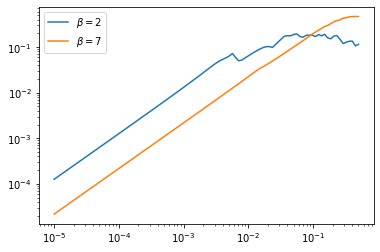

In [256]:
plt.loglog(potential_stds_array,norm_resid_max_LS,label=r'$\beta=2$')
plt.loglog(potential_stds_array,norm_resid_max_HS,label=r'$\beta=7$')
plt.legend()

In [ ]:
plt.loglog(potential_stds_array,norm_resid_max_LS,label=r'$\beta=2$')
plt.loglog(potential_stds_array,norm_resid_max_HS,label=r'$\beta=7$')
plt.legend()

In [238]:
np.where(potential_stds_array<1e-2)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]),)

In [258]:
from scipy.optimize import curve_fit

popt,_=curve_fit((lambda x,k,b: k*x+b),np.log10(potential_stds_array[:63]),np.log10(norm_resid_max_LS[:63]),p0=[1,0])
popt

array([0.97994628, 1.02504037])

In [259]:
from scipy.optimize import curve_fit

popt,_=curve_fit((lambda x,k,b: k*x+b),np.log10(potential_stds_array[:63]),np.log10(norm_resid_max_HS[:63]),p0=[1,0])
popt

array([1.00230166, 0.34866875])

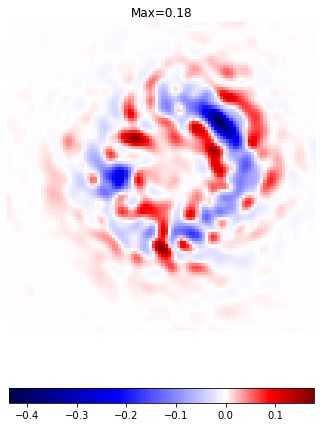

In [270]:
get_resid(0.045,2)

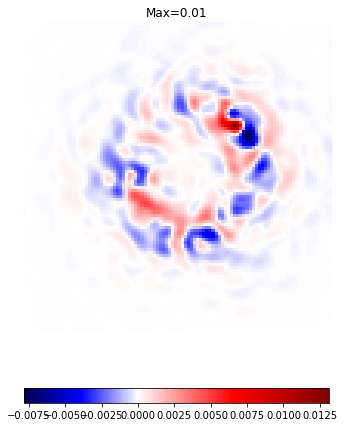

In [266]:
get_resid(0.001,2)

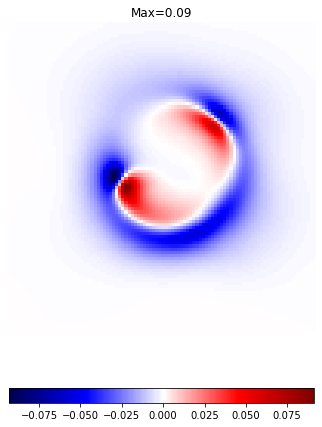

In [267]:
get_resid(0.045,7)

# Relation between A and physical characteristics of the GRF

So they should be linked as 

$A \propto \frac{\sigma^2_{\delta \psi}}{\sum_{k_x} \sum_{k_y} k^{-\beta}} 
    \propto \frac{\sigma^2_{\delta \alpha}}{\sum_{k_x} \sum_{k_y} k^{-\beta+2}}
    \propto \frac{\sigma^2_{\delta \kappa}}{\sum_{k_x} \sum_{k_y} k^{-\beta+4}}$

In [ ]:
potentials=np.zeros((len(logA_array),npix,npix))
deflections_x=np.zeros_like(potentials)
deflections_y=np.zeros_like(potentials)
convergences=np.zeros_like(potentials)
magnifications=np.zeros_like(potentials)
residuals=np.zeros_like(potentials)

for i in tqdm(range(len(logA_array))):
    potential,deflection,convergence,magnification,residual=get_GRF_characteristics(logA_array[i],Beta_array[i])
    
    potentials[i]=potential
    deflections_x[i]=deflection[0]
    deflections_y[i]=deflection[1]
    convergences[i]=convergence
    magnifications[i]=magnification
    residuals[i]=residual

In [22]:
def get_data(func):
    
    temp=np.array([logA_array,Beta_array,func(potentials),func(deflections_x),func(deflections_y),\
               func(convergences),func(magnifications),residuals.max(axis=(1,2)),residuals.std(axis=(1,2))**2])
    
    return temp
    
    
#temp=np.array([logA_array,Beta_array,potentials.std(axis=(1,2)),deflections_x.std(axis=(1,2)),deflections_y.std(axis=(1,2)),\
               #convergences.std(axis=(1,2)),residuals.max(axis=(1,2)),residuals.std(axis=(1,2))**2])

temp=get_data(lambda x: x.std(axis=(1,2))**2)

df=pd.DataFrame(data=temp.T,columns=['logA','Beta','pot','defx','defy','conv','magn','res_max','res_var'])
df['A']=np.power(10,df['logA'])

In [23]:
df

,logA,Beta,pot,defx,defy,conv,magn,res_max,res_var,A
0,-7.00,2.0,0.000225,0.006097,0.005792,24.147625,2988.424507,0.047689,0.000043,1.000000e-07
1,-7.32,3.0,0.000398,0.001388,0.001304,2.168258,22349.215255,0.047604,0.000031,4.786301e-08
2,-7.80,4.0,0.000873,0.000572,0.000624,0.150110,6468.766548,0.047497,0.000037,1.584893e-08
3,-8.45,5.0,0.001470,0.000491,0.000658,0.008661,0.041450,0.047483,0.000044,3.548134e-09
4,-9.27,6.0,0.001734,0.000473,0.000692,0.000687,0.002806,0.047816,0.000043,5.370318e-10
5,-10.10,7.0,0.002027,0.000516,0.000780,0.000277,0.001117,0.047951,0.000044,7.943282e-11


In [25]:
from jaxtronomy.GaussianRandomField.PowerBox_jaxified import get_k_grid_dx
k_grid,_=get_k_grid_dx(npix,pix_scl)

In [28]:
k_grid[50,50]=np.nan

In [30]:
df['Stat_sum']=[np.nansum(np.power(k_grid,-Beta)) for Beta in df['Beta']]

In [31]:
df

,logA,Beta,pot,defx,defy,conv,magn,res_max,res_var,A,Stat_sum
0,-7.00,2.0,0.000225,0.006097,0.005792,24.147625,2988.424507,0.047689,0.000043,1.000000e-07,1.782779e+03
1,-7.32,3.0,0.000398,0.001388,0.001304,2.168258,22349.215255,0.047604,0.000031,4.786301e-08,4.567283e+03
2,-7.80,4.0,0.000873,0.000572,0.000624,0.150110,6468.766548,0.047497,0.000037,1.584893e-08,2.468161e+04
3,-8.45,5.0,0.001470,0.000491,0.000658,0.008661,0.041450,0.047483,0.000044,3.548134e-09,1.667972e+05
4,-9.27,6.0,0.001734,0.000473,0.000692,0.000687,0.002806,0.047816,0.000043,5.370318e-10,1.221306e+06
5,-10.10,7.0,0.002027,0.000516,0.000780,0.000277,0.001117,0.047951,0.000044,7.943282e-11,9.275950e+06


In [35]:
def get_GRF_characteristics(logA,Beta):
    
    GRF_realisation=get_jaxified_GRF([logA,Beta],GRF_seed,npix,pix_scl)

    kwargs=[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]
    
    potential=GRF_lens_model.potential(xgrid, ygrid, kwargs)
    deflection=GRF_lens_model.alpha(xgrid, ygrid, kwargs)
    convergence=GRF_lens_model.kappa(xgrid, ygrid, kwargs)
    
    
    return potential,deflection,convergence

In [38]:
A_array=np.linspace(0,1,20)
Beta_array=np.linspace(1,10,20)
norm_pot=np.zeros((len(A_array),len(Beta_array)))
norm_defx=np.zeros((len(A_array),len(Beta_array)))
norm_defy=np.zeros((len(A_array),len(Beta_array)))
norm_conv=np.zeros((len(A_array),len(Beta_array)))

for i,A in tqdm(enumerate(A_array)):
    for j,B in enumerate(Beta_array):
        potential,deflection,convergence=get_GRF_characteristics(A,B)
        
        norm_pot[i,j]=(potential.std()**2)/np.nansum(np.power(k_grid,-B))
        norm_defx[i,j]=(deflection[0].std()**2)/np.nansum(np.power(k_grid,-B+2))
        norm_defy[i,j]=(deflection[1].std()**2)/np.nansum(np.power(k_grid,-B+2))
        norm_conv[i,j]=(convergence.std()**2)/np.nansum(np.power(k_grid,-B+4))

20it [00:57,  2.87s/it]


In [52]:
Beta_array

array([ 1.        ,  1.47368421,  1.94736842,  2.42105263,  2.89473684,
        3.36842105,  3.84210526,  4.31578947,  4.78947368,  5.26315789,
        5.73684211,  6.21052632,  6.68421053,  7.15789474,  7.63157895,
        8.10526316,  8.57894737,  9.05263158,  9.52631579, 10.        ])

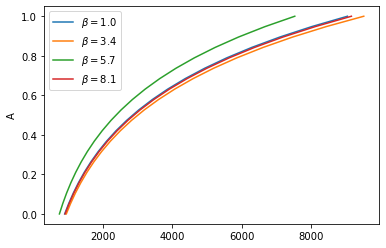

In [51]:
for i in range(0,20,5):
    plt.plot(norm_conv[:,i],A_array,label=r'$\beta=$'+'{:.1f}'.format(Beta_array[i]))

plt.ylabel('A')
plt.legend()

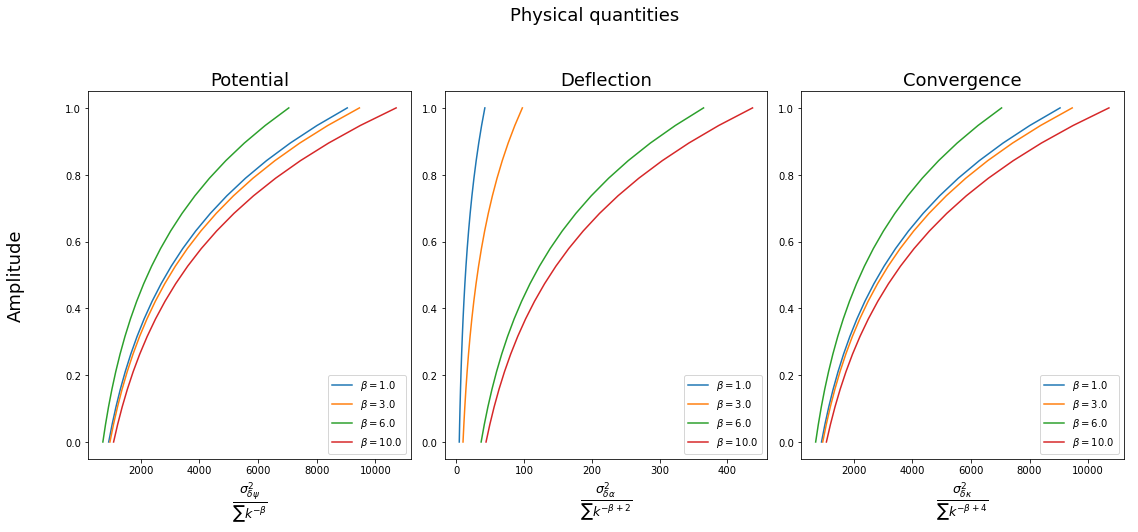

In [70]:
fig,ax=plt.subplots(1,3,figsize=(15,7))

Beta_indices=[0,4,11,-1]
Beta_labels=[1,3,6,10]

for i,Beta_index in enumerate(Beta_indices):
    ax[0].plot(norm_conv[:,Beta_index],A_array,label=r'$\beta=$'+'{:.1f}'.format(Beta_labels[i]))
    ax[0].set_title('Potential',fontsize=FS)
    ax[0].set_xlabel(r'$\frac{\sigma^2_{\delta \psi}}{\sum k^{-\beta}}$',fontsize=FS)
    ax[0].legend(loc='lower right')
    

for i,Beta_index in enumerate(Beta_indices):
    ax[1].plot(norm_defx[:,Beta_index],A_array,label=r'$\beta=$'+'{:.1f}'.format(Beta_labels[i]))
    ax[1].set_title('Deflection',fontsize=FS)
    ax[1].set_xlabel(r'$\frac{\sigma^2_{\delta \alpha}}{\sum k^{-\beta+2}}$',fontsize=FS)
    ax[1].legend(loc='lower right')
    
for i,Beta_index in enumerate(Beta_indices):
    ax[2].plot(norm_conv[:,Beta_index],A_array,label=r'$\beta=$'+'{:.1f}'.format(Beta_labels[i]))
    ax[2].set_title('Convergence',fontsize=FS)
    ax[2].set_xlabel(r'$\frac{\sigma^2_{\delta \kappa}}{\sum  k^{-\beta+4}}$',fontsize=FS)
    ax[2].legend(loc='lower right')
    
    
fig.suptitle('Physical quantities',fontsize=FS,y=1.05)
fig.tight_layout()  

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel('Amplitude',labelpad=40,fontsize=FS)
plt.show()   



<AxesSubplot:>

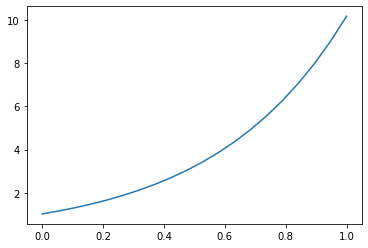

In [41]:
sns.lineplot(x=A_array,y=norm_pot[:,0])

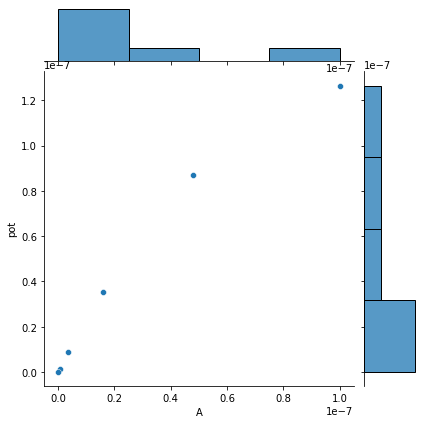

In [32]:
sns.jointplot(data=df,x='A',y=df['pot']/np.array([np.nansum(np.power(k_grid,-Beta)) for Beta in df['Beta']]))